## Predicting House Price

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

In [2]:
#Read dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
#Review dataset
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#Review dataset size and shapes
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

### Data Back Up

In [6]:
#take a back up copy of dataset
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

### Handling Outliers

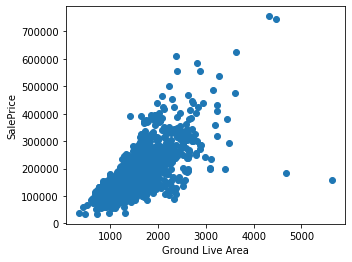

In [7]:
#Plot the outliers
plt.figure(figsize=(5,4))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.xlabel('Ground Live Area')
plt.ylabel('SalePrice')
plt.show();

In [8]:
df_train.shape

(1460, 81)

In [9]:
#Delete the outliers
delidx = df_train[df_train['GrLivArea']>4000].index
df_train = df_train.drop(delidx, axis=0)
df_train.shape

(1456, 81)

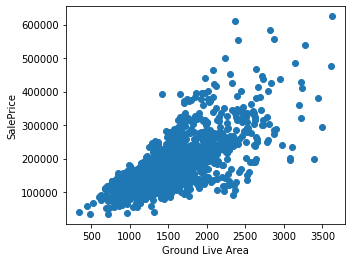

In [10]:
#review outliers removal
plt.figure(figsize=(5,4))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.xlabel('Ground Live Area')
plt.ylabel('SalePrice')
plt.show();

### Capture Total Number of rows in Train and Test

In [81]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
ntrain, ntest

(1456, 1459)

### Target Setup

In [12]:
#Target column is identified as House SalePrice
y_train = df_train['SalePrice'].values

In [13]:
#Drop column id as that do not contribute to calculate SalePrice
srs_testid = df_test['Id'] #Take backup of testid for final submission file

df_train.drop('Id', inplace=True, axis=1)
df_test.drop('Id', inplace=True, axis=1)

#Validate column reduction
df_train.shape, df_test.shape

((1456, 80), (1459, 79))

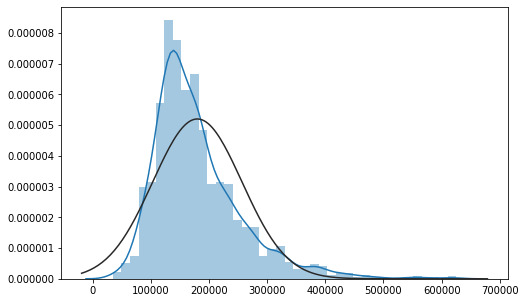

In [14]:
#Visualize target data
plt.figure(figsize=(8,5))
sb.distplot(y_train, fit=norm)
plt.show();

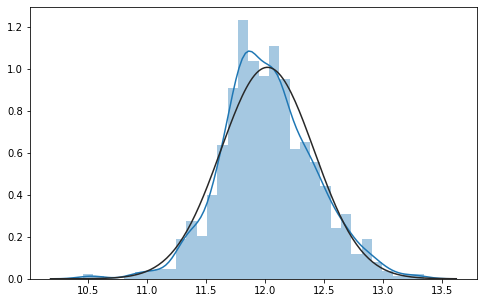

In [15]:
#Since its not normalized taking log1p to normalize it
plt.figure(figsize=(8,5))
sb.distplot(np.log1p(y_train), fit=norm)
plt.show();

In [16]:
#As the graph now shown to be normalized, Hence transforming yvalue to log1p
y_train = np.log1p(y_train)

### Building All Data

In [17]:
#Concate both train and test dataset for data transformation
df_alldata = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

#Review all data
df_alldata.shape

(2915, 80)

In [18]:
#drop target column SalePrice from all data
df_alldata.drop('SalePrice', 
               inplace=True,
               axis=1)

In [19]:
df_alldata.head(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008


## Data Munging

In [20]:
#Find null values in dataset
alldata_na = df_alldata.isnull().sum()
alldata_na = alldata_na[alldata_na>0]
alldata_na = alldata_na.sort_values(ascending=False)
print('No of columns with nulls: ', len(alldata_na))

No of columns with nulls:  34


## Handling Missing Values

In [21]:
#For selected columns below impute missing values with 'None'
nonecols=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','MSSubClass']

for col in nonecols:
    df_alldata[col] = df_alldata[col].fillna('None')

In [22]:
#For selected columns below impute missing values with 0
zerocols = ['GarageYrBlt','GarageArea','GarageCars', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']

for col in zerocols:
    df_alldata[col] = df_alldata[col].fillna(0)

In [23]:
#For selected columns below fill null with mode
modecols=['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

for col in modecols:
    df_alldata[col] = df_alldata[col].fillna(df_alldata[col].mode()[0])

In [24]:
#Drop the Utilities column
df_alldata.drop('Utilities', inplace=True, axis=1)

In [25]:
#Impute value 'Typ'
df_alldata['Functional'] = df_alldata.fillna('Typ')

In [26]:
#Impute lotfrontage null values with Neighbour hood median
df_alldata['LotFrontage'] = df_alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [27]:
#Lookout for missing null values again
nas = df_alldata.isnull().sum()
nas = nas[nas>0]
nas

Series([], dtype: int64)

In [28]:
#Add new column TotalSF
df_alldata['TotalSF'] = df_alldata['TotalBsmtSF'] + df_alldata['1stFlrSF'] + df_alldata['2ndFlrSF']

In [29]:
#Drop noise columns
dropcols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
df_alldata.drop(dropcols, inplace=True, axis=1)

In [30]:
#Convert these cols to numerical
df_alldata['Functional'] = df_alldata['Functional'].astype(float)

---

In [31]:
#Selecting numerical features
num_feats = df_alldata.select_dtypes(exclude='object').columns
num_feats

Index(['3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
       'Functional', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd',
       'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'TotalSF'],
      dtype='object')

In [32]:
catg_feats = df_alldata.dtypes[df_alldata.dtypes == 'object'].index
catg_feats

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'GarageCond', 'GarageFinish',
       'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape',
       'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive',
       'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType',
       'Street'],
      dtype='object')

In [33]:
#Before onehot encoding
df_beforeonehot = df_alldata.copy()

In [34]:
df_alldata.shape

(2915, 76)

In [35]:
df_alldata_copy = df_alldata.copy()

## Perform One hot Encoding

In [36]:
#Actual onehot encoding avoiding dummy variable trap
for col in catg_feats:
    df_temp = df_alldata[col]
    df_temp = pd.DataFrame(df_temp)
    df_temp = pd.get_dummies(df_temp, prefix = col)
    temp = df_temp.columns[0] #Delete one dummy variable
    df_temp.drop(temp, inplace=True, axis=1)
    df_alldata = pd.concat([df_alldata, df_temp], axis=1).reset_index(drop=True)
    df_alldata.drop(col, inplace=True, axis=1) #Delete actual column from dataframe

In [37]:
df_alldata.shape

(2915, 250)

### Skew data to normalize feature values

In [38]:
skew_feats = df_alldata[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_feats = skew_feats[skew_feats>0.5]
print('No of Features to be Skewed: ', len(skew_feats))
print(skew_feats[:10])

No of Features to be Skewed:  25
MiscVal          21.932147
PoolArea         18.701829
LotArea          13.123758
LowQualFinSF     12.080315
3SsnPorch        11.368094
KitchenAbvGr      4.298845
BsmtFinSF2        4.142863
EnclosedPorch     4.000796
ScreenPorch       3.943508
BsmtHalfBath      3.942892
dtype: float64


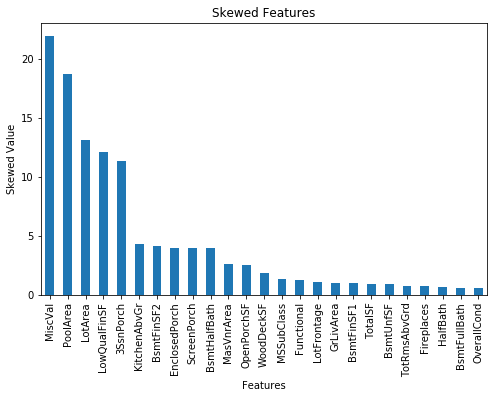

In [39]:
plt.figure(figsize=(8,5))
skew_feats.plot(kind='bar')
plt.title('Skewed Features')
plt.xlabel('Features')
plt.ylabel('Skewed Value')
plt.show()

In [40]:
#Perform Box Cox Transformation on selected features having skew value > 0.5
Lambda=0.15
for col in skew_feats.index:
    df_alldata[col] = boxcox1p(df_alldata[col], Lambda)
    
print('No of Features Skewed: ',skew_feats.shape[0])

No of Features Skewed:  25


## Building Training and Test Set

In [41]:
df_train = df_alldata[:ntrain]
df_test = df_alldata[ntrain:]

In [42]:
df_train.shape

(1456, 250)

In [43]:
y_train.shape

(1456,)

### Building Model Validation Functions

In [44]:
#Defining cross validation strategy
cross_val = KFold(n_splits=10, shuffle=True, random_state=42)

In [45]:
#Define function to calculate rmse during training
def rmse_train(model, x, y):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cross_val, n_jobs=-1))
    return rmse.mean()

In [46]:
#Find rmse for prediction
def rmse_pred(y, y_pred):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse

### Building Function for Submission

In [86]:
def Submission(prediction):
    df_pred = pd.DataFrame({'Id':srs_testid, 'SalePrice':prediction})
    print('Sample Prediction:', prediction[:5])
    
    #Defining file name
    tday = datetime.today()
    tm = str(tday.date().day)+str(tday.date().month)+str('_')+str(tday.time().hour)+str(tday.time().minute)+str(tday.time().second)
    fn = 'Submission_'
    fn = str(fn)+str(tm)+str('.csv')
    
    #Saving prediction to csv
    df_pred.to_csv(fn, index=False)
    print('Submission file saved to', os.path.realpath(fn))

---

### Building Model

In [52]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold, train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgbm

In [68]:
#Defining training inputs
X_train = df_train.values
y_train = y_train

#Define test inputs
X_test = df_test.values

In [100]:
alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 2, 10, 20, 50]

In [60]:
#Building Lasso Model
lcv = LassoCV(alphas=alphas, random_state=42, cv=cross_val, n_jobs=-1, max_iter=10000)

In [61]:
lcv.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06,
                0.1, 0.3, 0.6, 1, 2, 10, 20, 50],
        copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True),
        eps=0.001, fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=-1,
        normalize=False, positive=False, precompute='auto', random_state=42,
        selection='cyclic', tol=0.0001, verbose=False)

In [62]:
#Optimum alpha value for lasso model
lcv.alpha_

0.0001

In [69]:
regressor_lasso = Lasso(alpha=0.0001, random_state=42)
regressor_lasso.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [71]:
#Review RMSE values for Lasso
print('Training RMSE:',rmse_train(regressor_lasso, X_train, y_train))

Training RMSE: 0.11285587929536853


In [75]:
#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, regressor_lasso.predict(X_train)))

Testing RMSE: 0.09429255976344748


In [87]:
#Scoring Lasso prediction
pred = regressor_lasso.predict(X_test)
pred = np.expm1(pred)
Submission(pred)

Sample Prediction: [120740.87946498 148424.68214403 187129.50619997 202104.97721921
 196114.56869003]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_192325.csv


## Secured Best score so far - 0.11976

### Building Ridge Model

In [101]:
alphas2 = [10, 12, 16, 12.5, 17, 10.001]

In [92]:
rcv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=cross_val)

In [93]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=array([10.   , 12.   , 16.   , 12.5  , 17.   , 10.001]),
        cv=KFold(n_splits=10, random_state=42, shuffle=True),
        fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [94]:
rcv.alpha_

10.0

In [96]:
regressor_ridge = Ridge(alpha=10, max_iter=10000, random_state=42)

In [97]:
regressor_ridge.fit(X_train,y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [98]:
pred_ridge = regressor_ridge.predict(X_train)

In [99]:
#Review Train RMSE values
print('Training RMSE:',rmse_train(regressor_ridge, X_train, y_train))

#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, pred_ridge))

Training RMSE: 0.11255349625805448
Testing RMSE: 0.09852806103860007


In [104]:
#Make Test Prediction
pred_ridge = regressor_ridge.predict(X_test)
pred_ridge = np.expm1(pred_ridge)
Submission(pred_ridge)

Sample Prediction: [118059.6194694  152781.21916423 186076.00534812 200735.76670233
 194784.34427982]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_193328.csv


## Next Best Score - 0.11792

In [105]:
#Test both lasso and ridge
pred = regressor_lasso.predict(X_test)*0.5 + regressor_ridge.predict(X_test)*0.5
pred = np.expm1(pred)
Submission(pred)

Sample Prediction: [119392.72297376 150587.19707709 186602.01230947 201419.20851494
 195448.32480293]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_194055.csv


### Secured score - 0.11814 (not an improvement)

### Build ElasticNet Model

In [109]:
alphas

[0.0001,
 0.0003,
 0.0006,
 0.001,
 0.003,
 0.006,
 0.01,
 0.03,
 0.06,
 0.1,
 0.3,
 0.6,
 1,
 2,
 10,
 20,
 50]

In [106]:
ecv = ElasticNetCV(alphas=alphas, max_iter=10000, cv=cross_val, random_state=42)

In [107]:
ecv.fit(X_train, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1, 2, 10, 20, 50],
             copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True),
             eps=0.001, fit_intercept=True, l1_ratio=0.5, max_iter=10000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
             verbose=0)

In [108]:
ecv.alpha_

0.0003

In [110]:
regressor_elastic = ElasticNet(alpha=0.0003, max_iter=10000, random_state=42)

In [111]:
regressor_elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
pred_elastic = regressor_elastic.predict(X_train)

In [113]:
#Review Train RMSE values
print('Training RMSE:',rmse_train(regressor_elastic, X_train, y_train))

#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, pred_elastic))

Training RMSE: 0.1124468737295096
Testing RMSE: 0.09598974133311955


In [114]:
#Make Test Prediction
pred = regressor_elastic.predict(X_test)
pred = np.expm1(pred)
Submission(pred)

Sample Prediction: [119776.8710773  149830.06388207 186615.56068739 201963.4944758
 197205.26841979]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_195043.csv


### Secured - 0.11838

In [115]:
#Testing lasso, elastic and ridge
pred = regressor_lasso.predict(X_test)*0.25 + regressor_ridge.predict(X_test)*0.5 + regressor_elastic.predict(X_test)*0.25
pred = np.expm1(pred)
Submission(pred)

Sample Prediction: [119153.69496288 150942.40274282 186473.75594633 201383.94858823
 195719.50848539]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_195544.csv


### Secured - 0.11793

In [119]:
#Fine tuning l1 ratio in elasticnet
l1r = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6,.05, .15, .5, .7, .9, .95, .99, 1]
ecv = ElasticNetCV(alphas=alphas, max_iter=10000, cv=cross_val, random_state=42, l1_ratio=l1r)
ecv.fit(X_train, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1, 2, 10, 20, 50],
             copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True),
             eps=0.001, fit_intercept=True,
             l1_ratio=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                       0.06, 0.1, 0.3, 0.6, 0.05, 0.15, 0.5, 0.7, 0.9, 0.95,
                       0.99, 1],
             max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=42,
             selection='cyclic', tol=0.0001, verbose=0)

In [120]:
ecv.alpha_

0.0003

In [121]:
ecv.l1_ratio_

0.5

In [122]:
regressor_elastic2 = ElasticNet(alpha=0.0003, max_iter=10000, random_state=42, selection='random')

In [123]:
regressor_elastic2.fit(X_train, y_train)

ElasticNet(alpha=0.0003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='random', tol=0.0001, warm_start=False)

In [124]:
pred_elastic = regressor_elastic2.predict(X_train)
#Review Train RMSE values
print('Training RMSE:',rmse_train(regressor_elastic2, X_train, y_train))

#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, pred_elastic))

Training RMSE: 0.1124509502483075
Testing RMSE: 0.09599756764097522


In [125]:
#Make Test Prediction
pred = regressor_elastic2.predict(X_test)
pred = np.expm1(pred)
Submission(pred)

Sample Prediction: [119779.87811868 149849.42456061 186613.95367185 201960.99477239
 197214.42615379]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_201459.csv


### Secured - 0.11837

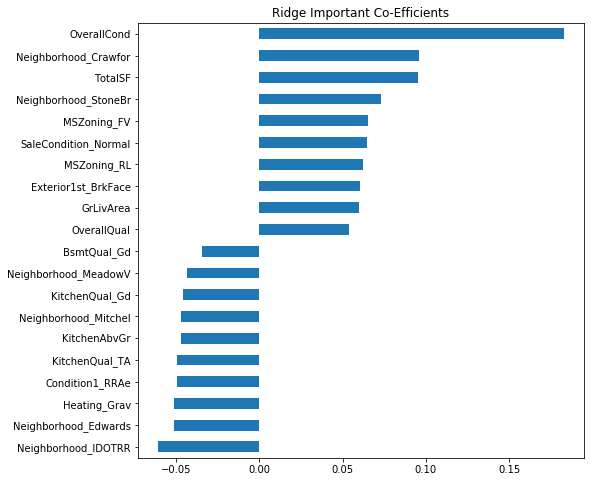

In [130]:
srs_rid_coef = pd.Series(regressor_ridge.coef_, index=df_train.columns)
df_rid_impc = pd.concat([srs_rid_coef.sort_values().head(10), srs_rid_coef.sort_values().tail(10)])

#Plot graph
plt.figure(figsize=(8,8))
df_rid_impc.plot(kind='barh')
plt.title('Ridge Important Co-Efficients')
plt.show();

In [134]:
sum(srs_rid_coef ==0)

0

### Building Voting Regressor Model

In [135]:
from sklearn.ensemble import VotingRegressor

In [136]:
regressor_vote = VotingRegressor([('ElasticNet', regressor_elastic), ('Ridge', regressor_ridge), ('Lasso', regressor_lasso)])

In [137]:
reg_vote = regressor_vote.fit(X_train, y_train)

In [138]:
pred_vote = reg_vote.predict(X_train)

In [139]:
#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, pred_vote))

Testing RMSE: 0.0958458356092795


In [153]:
pred_vote = regressor_vote.predict(X_test)
pred = np.expm1(pred_vote)
Submission(pred)

Sample Prediction: [119520.63525404 150334.39518846 186606.52832615 201600.47399213
 196032.22654097]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_213154.csv


### Secured - 0.11816

### Building Stacking Regressor Model

In [142]:
from mlxtend.regressor import StackingRegressor

In [149]:
stk_reg = StackingRegressor(regressors=[regressor_lasso, regressor_elastic, regressor_elastic2, regressor_ridge], 
                            meta_regressor=regressor_ridge,
                           use_features_in_secondary=True)

In [150]:
regressor_stack = stk_reg.fit(X_train, y_train)

In [151]:
pred_stack = regressor_stack.predict(X_train)

In [152]:
#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, pred_stack))

Testing RMSE: 0.09580063248223486


In [154]:
pred_stack = regressor_stack.predict(X_test)
pred = np.expm1(pred_stack)
Submission(pred)

Sample Prediction: [119078.75350354 150546.48295541 186519.45177988 201438.209838
 195434.97692775]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_213357.csv


In [148]:
pred_vote = regressor_vote.predict(X_test)
pred_stack = regressor_stack.predict(X_test)

pred = pred_vote*0.5 + pred_stack*0.5
pred = np.expm1(pred)
Submission(pred)

Sample Prediction: [119307.75275425 150427.89340685 186547.76762179 201503.92489558
 195706.86861186]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_204916.csv


In [ ]:
[119307.75275425 150427.89340685 186547.76762179 201503.92489558
 195706.86861186]

In [155]:
pred = (regressor_lasso.predict(X_train) + regressor_ridge.predict(X_train) + regressor_elastic.predict(X_train) 
        + regressor_vote.predict(X_train) + regressor_stack.predict(X_train))/5

In [156]:
#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, pred))

Testing RMSE: 0.09581832493019048


In [157]:
pred = np.expm1(pred)
pred[:5]

array([206892.06346226, 192926.0312374 , 218257.591916  , 164545.76830127,
       292930.83001627])

### Scaling data using Robust Scaler

In [158]:
from sklearn.preprocessing import RobustScaler

In [159]:
Rscale = RobustScaler()

In [160]:
x_train = Rscale.fit_transform(X_train) #Scaled train data

In [161]:
x_test = Rscale.transform(X_test) #Scaled test data

In [162]:
lcv = LassoCV(alphas=alphas, random_state=42, cv=cross_val, n_jobs=-1, max_iter=10000)
lcv.fit(x_train, y_train)
#Optimum alpha value for lasso model
lcv.alpha_

0.0001

In [166]:
regressor_lasso = Lasso(alpha=0.0001, random_state=42)
regressor_lasso.fit(x_train,y_train)
#Review RMSE values for Lasso
print('Training RMSE:',rmse_train(regressor_lasso, x_train, y_train))
#Making prediction and review Test RMSE
print('Testing RMSE:',rmse_pred(y_train, regressor_lasso.predict(x_train)))

Training RMSE: 0.11279841538057853
Testing RMSE: 0.09429862932472582


In [168]:
pred = regressor_lasso.predict(x_test)
pred = np.expm1(pred)
pred[:5]

array([120618.46765221, 148212.79499133, 186770.66334135, 202007.16932628,
       195780.3100201 ])

In [ ]:
[118059.6194694  152781.21916423 186076.00534812 200735.76670233
 194784.34427982]

In [169]:
Submission(pred)

Sample Prediction: [120618.46765221 148212.79499133 186770.66334135 202007.16932628
 195780.3100201 ]
Submission file saved to C:\Users\rajas\Kaggle\HousePrice\Submission_511_215357.csv


### Scored - 0.11973